# Общее описание проекта

В этом конкурсе ваша задача - разработать модель для предсказания успешности стартапа (закроется или нет)

**Данные**\
Датасет состоит из двух файлов: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'

kaggle_startups_train_01.csv - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.\
kaggle_startups_test_01.csv - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'status' для каждого стартапа из этого датасета.\
kaggle_startups_sample_submit_01.csv - файл с примером предсказаний в правильном формате.\
name - идентификатор (название) стартапа в тестовом наборе.\
status - целевой признак. Для каждого стартапа предскажите категориальное значение соответствующее прогнозу ['operating', 'closed'].\

**Описание полей данных**\
name - Название стартапа\
category_list - Список категорий, к которым относится стартап\
funding_total_usd - Общая сумма финансирования в USD\
status - Статус стартапа (закрыт или действующий)\
country_code - Код страны\
state_code - Код штата\
region - Регион\
city - Город\
funding_rounds - Количество раундов финансирования\
founded_at - Дата основания\
first_funding_at - Дата первого раунда финансирования\
last_funding_at - Дата последнего раунда финансирования\
closed_at - Дата закрытия стартапа (если применимо)\
lifetime - Время существования стартапа в днях

# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
import uuid
from datetime import datetime
from collections import Counter
#Plot
import matplotlib.pyplot as plt
import seaborn as sns
#sclearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error, \
                            precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.metrics import make_scorer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import optuna
from optuna.integration import OptunaSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.dummy import DummyClassifier
from category_encoders import TargetEncoder
#phik
from phik import resources
from phik.report import plot_correlation_matrix
from phik import phik_matrix
#stat
from scipy.stats import ttest_ind

from catboost import CatBoostClassifier

In [2]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)     
pd.set_option('display.width', None)        
pd.set_option('display.max_colwidth', None) 

# Загрузка данных

In [3]:
try:
    train_df = pd.read_csv(r"C:\Users\bondarev\Documents\DS study\data\ms_1\kaggle_startups_train_28062024.csv")
    test_df = pd.read_csv(r"C:\Users\bondarev\Documents\DS study\data\ms_1\kaggle_startups_test_28062024.csv")
    sample_submit = pd.read_csv(r"C:\Users\bondarev\Documents\DS study\data\ms_1\kaggle_startups_sample_submit_28062024.csv")
except Exception as e:
    print(e)

## Предварительный общий обзор

Тренировочные данные:

In [4]:
train_df.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


In [5]:
train_df.shape

(52516, 13)

Данные тестовой выборки:

In [6]:
test_df.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


In [7]:
test_df.shape

(13125, 11)

Пример предсказаний:

In [8]:
sample_submit.head()

,name,status
0,Crystalsol,closed
1,JBI Fish & Wings,operating
2,COINPLUS,closed
3,Imagine Communications,closed
4,DNA13,operating


In [9]:
sample_submit.shape

(13125, 2)

**Вывод:**\
Выполнен предварительный обзор данных. Данные соответствуют описанию.

# Обзор данных

In [10]:
# функция для обзора данных
def data_overview(df, discret_values=20):
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    # 1. Выводим первые 5 строк
    print("Первых 5 строк данных:")
    display(df.head())

    # 2. Информация о DataFrame
    print("\nИнформация о DataFrame:")
    df.info()

    # 3. Количество пропусков
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    missing_df = pd.DataFrame({
        'Пропуски (шт)': missing_data,
        'Пропуски (%)': missing_percent
    })
    missing_df = missing_df[missing_df['Пропуски (шт)'] > 0]
    print("\nКоличество пропусков (в шт и в %):")
    display(missing_df.style.background_gradient(cmap="YlOrRd"))

    # 4. Количество явных дубликатов
    try:
        duplicates_count = df.duplicated().sum()
        print(f"\nКоличество явных дубликатов: {duplicates_count}")
    except TypeError:
        # Преобразуем все элементы в строку (не изменяя сам df!)
        df_str = df.applymap(lambda x: str(x) if isinstance(x, (list, dict, set)) else x)
        duplicates_count = df_str.duplicated().sum()
        print(f"\nКоличество явных дубликатов (с преобразованием в строки): {duplicates_count}")

    # 5. Уникальные значения по нечисловым полям
    non_numeric_cols = df.select_dtypes(exclude=["number", "datetime"])
    non_list_cols = [
        col for col in non_numeric_cols.columns
        if not df[col].apply(lambda x: isinstance(x, (list, dict, set))).any()]
    non_numeric_cols = df[non_list_cols]
    print("\nУникальные значения по нечисловым полям:")
    for col in non_numeric_cols.columns:
        unique_values = non_numeric_cols[col].unique()
        print(f"{col}: {unique_values[:10]}{'...' if len(unique_values) > 10 else ''}")
        try:
            cnt = df[col].nunique()
            print(f"Кол-во уникальных значений: {cnt}")
        except TypeError:
            print("Кол-во уникальных значений: невозможно определить (нехэшируемые объекты)")
        print('')

    # 6. Минимальное и максимальное значение для полей с датами
    date_cols = df.select_dtypes(include=["datetime"])
    if not date_cols.empty:
        print("\nМинимальные и максимальные значения для полей с датами:")
        for col in date_cols.columns:
            print(f"{col}: min = {df[col].min()}, max = {df[col].max()}")

    # 7. Описательная статистика, исключая поля с 'id'
    numeric_cols = df.select_dtypes(include=["number"]).columns
    numeric_cols_no_id = [col for col in numeric_cols if 'id' not in col.lower()]
    if numeric_cols_no_id:
        print("\nОписательная статистика для числовых полей (без 'id'):")
        display(df[numeric_cols_no_id].describe())
    else:
        print("\nНет числовых полей без 'id' для описательной статистики.")

    # 8. Определение типа признака и построение графиков
    if numeric_cols_no_id:
        for col in numeric_cols_no_id:
            unique_values = df[col].nunique()
            if unique_values <= discret_values:  # Дискретный признак
                print(f"\nДискретный признак: {col}")
                fig, axes = plt.subplots(1, 2, figsize=(12, 5))
                sns.countplot(data=df, x=col, order=df[col].value_counts().index,  ax=axes[0])
                axes[0].set_title(f"Столбчатая диаграмма: {col}")
                axes[0].tick_params(axis='x', rotation=45)
                sns.boxplot(x=df[col], ax=axes[1])
                axes[1].set_title(f"Boxplot: {col}")
                plt.tight_layout()
                plt.show()
            else:  # Непрерывный признак
                print(f"\nНепрерывный признак: {col}")
                fig, axes = plt.subplots(1, 2, figsize=(12, 5))
                sns.histplot(df[col].dropna(), ax=axes[0], kde=True)
                axes[0].set_title(f"Гистограмма: {col}")
                sns.boxplot(x=df[col], ax=axes[1])
                axes[1].set_title(f"Boxplot: {col}")
                plt.tight_layout()
                plt.show()
    else:
        print("\nНет числовых полей без 'id' для построения графиков.")

## Тренировочные данные

Первых 5 строк данных:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN



Информация о DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB

Количество пропусков (в шт и в %):


,Пропуски (шт),Пропуски (%)
name,1,0.001904
category_list,2465,4.693808
funding_total_usd,10069,19.173204
country_code,5502,10.476807
state_code,6763,12.877980
region,6359,12.108691
city,6359,12.108691
closed_at,47599,90.637139



Количество явных дубликатов: 0

Уникальные значения по нечисловым полям:
name: ['Lunchgate' 'EarLens' 'Reviva Pharmaceuticals' 'Sancilio and Company'
 'WireTough Cylinders' 'Connected Sports Ventures' 'Attensity'
 'Mesh Networks' 'AngioScore' 'Vidatronic']...
Кол-во уникальных значений: 52515

category_list: ['Online Reservations|Restaurants' 'Manufacturing|Medical|Medical Devices'
 'Biotechnology' 'Health Care' 'Manufacturing' 'Mobile'
 'Analytics|Business Analytics|Social CRM|Social Media Monitoring|Software'
 'Software' 'Semiconductors' 'Clean Technology']...
Кол-во уникальных значений: 22105

status: ['operating' 'closed']
Кол-во уникальных значений: 2

country_code: ['CHE' 'USA' nan 'GBR' 'RUS' 'ESP' 'FRA' 'SWE' 'IND' 'KOR']...
Кол-во уникальных значений: 134

state_code: ['25' 'CA' nan 'VA' 'NJ' 'TX' 'OR' 'FL' 'WA' 'NY']...
Кол-во уникальных значений: 300

region: ['Zurich' 'SF Bay Area' nan 'VA - Other' 'Newark' 'Houston' 'Austin'
 'Portland, Oregon' 'Tampa' 'Seattle']...
Кол-в

,funding_total_usd,funding_rounds
count,4.244700e+04,52516.000000
mean,1.824748e+07,1.740670
std,1.871173e+08,1.374522
min,1.000000e+00,1.000000
25%,3.360275e+05,1.000000
50%,2.000000e+06,1.000000
75%,1.000000e+07,2.000000
max,3.007950e+10,19.000000



Непрерывный признак: funding_total_usd


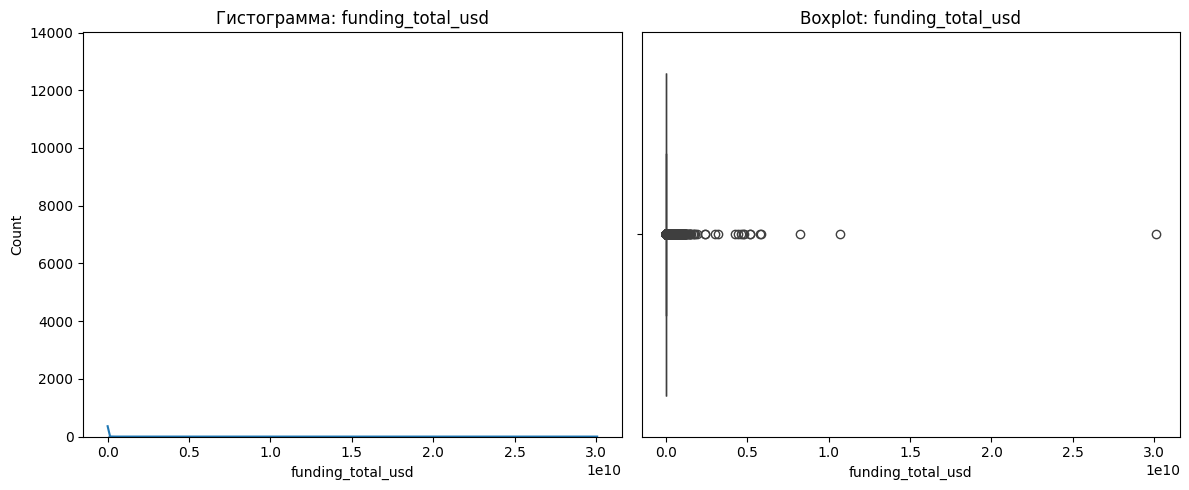


Дискретный признак: funding_rounds


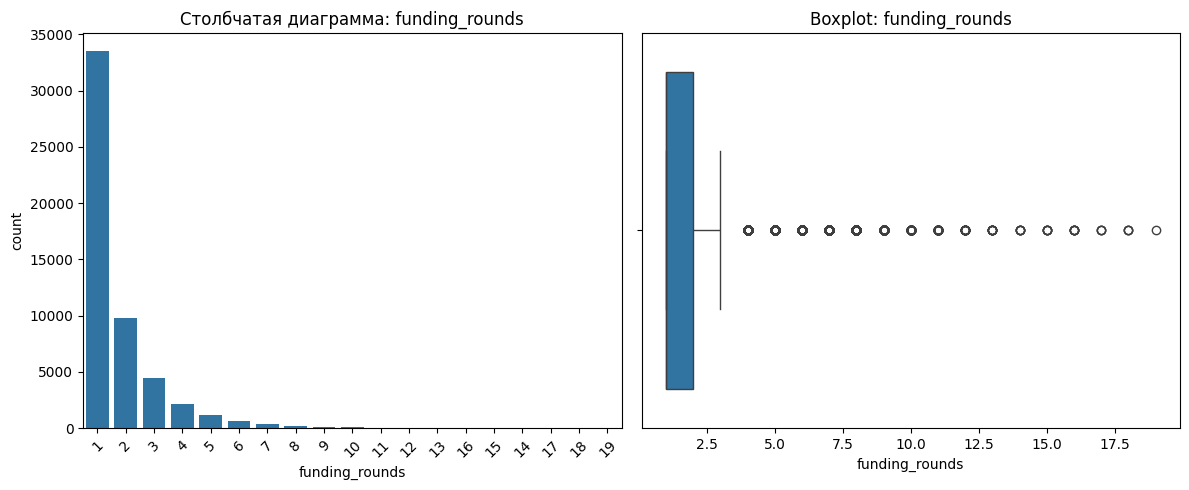

In [11]:
data_overview(train_df)

**Вывод:**\
Обнаружены пропуски в полях name, category_list, funding_total_usd, country_code, state_code, region, city, closed_at.\
Явные и неявные дубликаты не обнаружены.\
Требуется преобразование типа данных в полях с датами.\
Поле category_list содержит слишком большое значение уникальных значений из-за "склеивания" всех категорий стартаппов. 

## Тестовые данные (признаки)

Первых 5 строк данных:


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209



Информация о DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB

Количество пропусков (в шт и в %):


,Пропуски (шт),Пропуски (%)
category_list,591,4.502857
funding_total_usd,2578,19.641905
country_code,1382,10.529524
state_code,1695,12.914286
region,1589,12.106667
city,1587,12.091429



Количество явных дубликатов: 0

Уникальные значения по нечисловым полям:
name: ['Crystalsol' 'JBI Fish & Wings' 'COINPLUS' 'Imagine Communications'
 'DNA13' 'Quickfire Games' 'Sente Inc.' 'Triosyn' 'Urgent.ly'
 'Map Decisions']...
Кол-во уникальных значений: 13125

category_list: ['Clean Technology' 'Hospitality' 'Finance'
 'Software|Video|Video Streaming' 'Software' 'Design|Entertainment|Games'
 'Biotechnology' 'Health Care|Medical|Therapeutics'
 'Consulting|Enterprises' 'Mobile']...
Кол-во уникальных значений: 6206

country_code: ['NIC' 'USA' 'LUX' 'CAN' nan 'MYS' 'DEU' 'GBR' 'FRA' 'ITA']...
Кол-во уникальных значений: 96

state_code: ['17' 'TN' '3' 'CA' 'ON' nan 'VA' 'PA' 'AZ' '14']...
Кол-во уникальных значений: 235

region: [nan 'TN - Other' 'Esch-sur-alzette' 'San Diego' 'Ottawa'
 'Washington, D.C.' 'Allentown' 'Phoenix' 'Kuala Lumpur' 'Cologne']...
Кол-во уникальных значений: 688

city: [nan 'Humboldt' 'Esch-sur-alzette' 'San Diego' 'Ottawa' 'Encinitas'
 'Sterling' 'Bethlehem' 

,funding_total_usd,funding_rounds,lifetime
count,1.054700e+04,13125.000000,13125.000000
mean,1.654910e+07,1.714438,3097.609524
std,9.217283e+07,1.318800,2128.356554
min,1.000000e+00,1.000000,52.000000
25%,3.200000e+05,1.000000,1726.000000
50%,2.000000e+06,1.000000,2526.000000
75%,1.000000e+07,2.000000,3866.000000
max,4.715000e+09,15.000000,17167.000000



Непрерывный признак: funding_total_usd


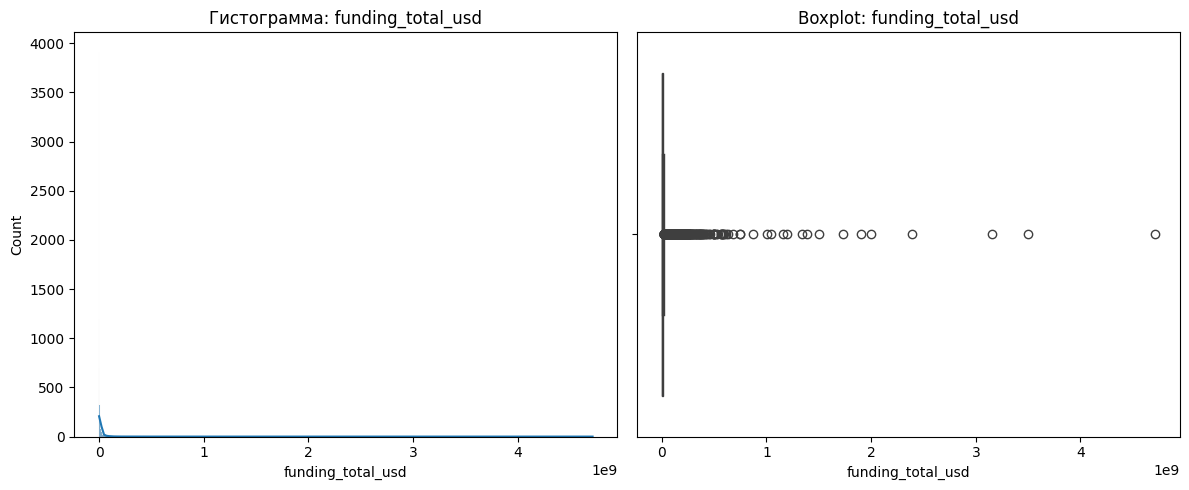


Дискретный признак: funding_rounds


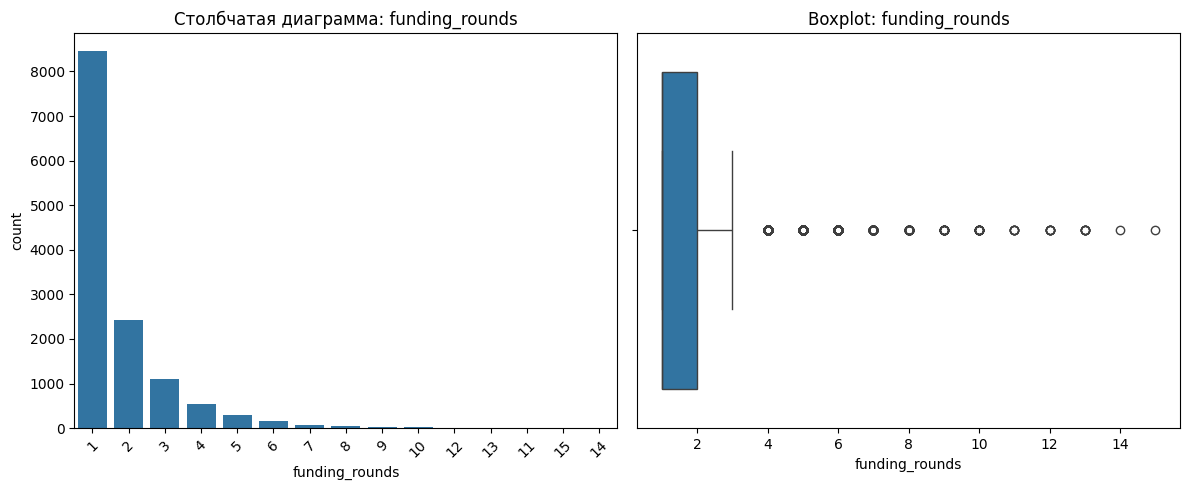


Непрерывный признак: lifetime


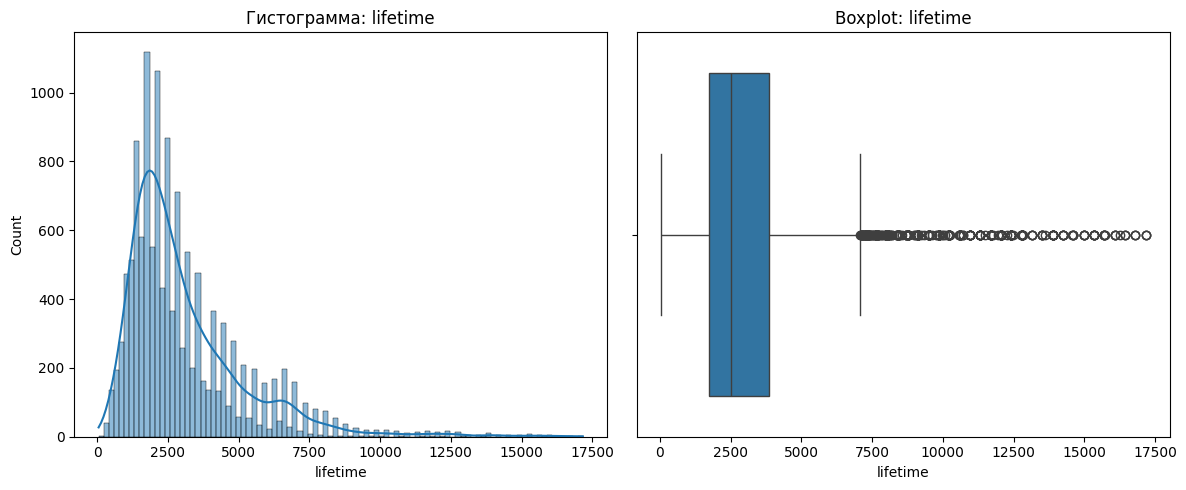

In [12]:
data_overview(test_df)

**Вывод:**\
Обнаружены пропуски в полях category_list, funding_total_usd, country_code, state_code, region, city.\
Явные и неявные дубликаты не обнаружены.\
Требуется преобразование типа данных в полях с датами.\
в данных присутствует дополнительный признак lifetime, которого нет в тренировочных данных.

## Примеры предсказаний

In [13]:
data_overview(sample_submit)

Первых 5 строк данных:


,name,status
0,Crystalsol,closed
1,JBI Fish & Wings,operating
2,COINPLUS,closed
3,Imagine Communications,closed
4,DNA13,operating



Информация о DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    13125 non-null  object
 1   status  13125 non-null  object
dtypes: object(2)
memory usage: 205.2+ KB

Количество пропусков (в шт и в %):


,Пропуски (шт),Пропуски (%)



Количество явных дубликатов: 0

Уникальные значения по нечисловым полям:
name: ['Crystalsol' 'JBI Fish & Wings' 'COINPLUS' 'Imagine Communications'
 'DNA13' 'Quickfire Games' 'Sente Inc.' 'Triosyn' 'Urgent.ly'
 'Map Decisions']...
Кол-во уникальных значений: 13125

status: ['closed' 'operating']
Кол-во уникальных значений: 2


Нет числовых полей без 'id' для описательной статистики.

Нет числовых полей без 'id' для построения графиков.


**Вывод:**\
Визуально видимых ошибок в заполнении данных не обнаружено. Преобразование типов данных не требуется.\
Пропуски не обнраужены.\
Явные и неявные дубликаты не обнаружены.

## Общий вывод

*Тренировочные данные:*\
Обнаружены пропуски в полях name, category_list, funding_total_usd, country_code, state_code, region, city, closed_at.\
Явные и неявные дубликаты не обнаружены.\
Требуется преобразование типа данных в полях с датами.\
Видны аномальные значения в funding_total_usd.\
Поле category_list содержит слишком большое значение уникальных значений из-за "склеивания" всех категорий стартаппов.

*Тестовые данные:*\
Обнаружены пропуски в полях category_list, funding_total_usd, country_code, state_code, region, city.\
Явные и неявные дубликаты не обнаружены.\
Требуется преобразование типа данных в полях с датами.\
в данных присутствует дополнительный признак lifetime, которого нет в тренировочных данных.

*Пример предсказаний:*\
Визуально видимых ошибок в заполнении данных не обнаружено. Преобразование типов данных не требуется.\
Пропуски не обнаружены.\
Явные и неявные дубликаты не обнаружены.
Видны аномальные значения в funding_total_usd.

# Предобработка данных

## Тренировочные данные

### Обработка пропусков

Посмотрим строки с пропущенным названием

In [14]:
train_df[train_df['name'].isna()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3291,NaN,Startups,25000.0,closed,USA,OR,"Portland, Oregon",Portland,1,2011-10-01,2012-03-01,2012-03-01,2013-06-03


In [15]:
# заполним название заглушкой
train_df['name'] = train_df['name'].fillna('unknown')

In [16]:
#проверка преобразований
train_df.isna().sum()

name                     0
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64

Удалим записи, где не указана категория, пропущено значение funding_total_usd (вероятно, если оно не указано, то 0) и компания закрыта. Такие записи врядли добавит информативности для модели. 

In [17]:
train_df = train_df[~((train_df['category_list'].isna()) & (train_df['funding_total_usd'].isna()) & (train_df['status'] == 'closed'))]

funding_total_usd заполним 0, category_list заполним на 'unknown'

In [18]:
train_df['funding_total_usd'] = train_df['funding_total_usd'].fillna(0)
train_df['category_list'] = train_df['category_list'].fillna('unknown')

Геоданные корректно заполнить не можем, оставим как есть.

In [19]:
#проверка преобразований
train_df.isna().sum()

name                     0
category_list            0
funding_total_usd        0
status                   0
country_code          5193
state_code            6449
region                6047
city                  6047
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64

### Преобразование типов данных

Преобразуем поля с датами в соответствующий тип данных:

In [20]:
date_columns = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']

for col in date_columns:
    train_df[col] = pd.to_datetime(train_df[col], errors='coerce')

### Проверим аномальные значения

In [21]:
np.percentile(train_df['funding_total_usd'], [95, 99])

array([5.64130231e+07, 1.91686984e+08])

In [22]:
# удалим экстримально высокие значения, которые выше 99го перцентиля, т.к. они могут исказить результаты
train_df = train_df[train_df['funding_total_usd'] < 1.91686984e+08]

### Добавим лайтайм

In [23]:
observation_date = pd.to_datetime("2018-01-01")

In [24]:
train_df["lifetime"] = (train_df["closed_at"].fillna(observation_date) - train_df["founded_at"]).dt.days

In [25]:
#добавим кол-во дней между первым и последним раундом финансирования на дату выгрузки
train_df["funding_dt_diff"] = (train_df["last_funding_at"].fillna(observation_date) - train_df["first_funding_at"]).dt.days

In [26]:
train_df.head(2)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,funding_dt_diff
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,2998,1310
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,4748,1393


### Обработка значений в category_list

In [27]:
#функция для преобразования строки в список категорий
def clean_and_split_categories(x):
    if pd.isna(x):
        return []
    # Разбиваем по |, убираем лишние пробелы, приводим к нижнему регистру
    return list(set(part.strip().lower() for part in x.split('|') if part.strip()))

In [28]:
train_df['category_list_clean'] = train_df['category_list'].apply(clean_and_split_categories)

In [29]:
category_counter = Counter()

for cats in train_df['category_list_clean']:
    category_counter.update(cats)

print(f"Всего уникальных категорий: {len(category_counter)}")
print(category_counter.most_common(20))

Всего уникальных категорий: 855
[('software', 6977), ('mobile', 4366), ('biotechnology', 3596), ('e-commerce', 3262), ('curated web', 2396), ('social media', 2275), ('enterprise software', 2168), ('unknown', 2020), ('advertising', 1971), ('health care', 1842), ('games', 1800), ('internet', 1640), ('saas', 1581), ('health and wellness', 1502), ('education', 1485), ('analytics', 1468), ('apps', 1460), ('finance', 1426), ('technology', 1423), ('clean technology', 1173)]


Cделаем из них отдельные поля с бинаным признаком:

In [30]:
from itertools import chain

all_categories = set(chain.from_iterable(train_df['category_list_clean']))

In [31]:
def categorize_all(cats):
    cats_set = set(cats)
    return pd.Series({cat: int(cat in cats_set) for cat in all_categories})

In [32]:
category_features = train_df['category_list_clean'].apply(categorize_all)
train_df = pd.concat([train_df, category_features], axis=1)

In [33]:
category_sums = category_features.sum().sort_values(ascending=False)
print(category_sums)

software                                 6977
mobile                                   4366
biotechnology                            3596
e-commerce                               3262
curated web                              2396
social media                             2275
enterprise software                      2168
unknown                                  2020
advertising                              1971
health care                              1842
games                                    1800
internet                                 1640
saas                                     1581
health and wellness                      1502
education                                1485
analytics                                1468
apps                                     1460
finance                                  1426
technology                               1423
clean technology                         1173
hardware + software                      1162
services                          

Вывод:\
Выполнено заполнение пропусков там, где это возможно. Так, одно пропущенное значение в названии заменено заглушкой 'unknown', funding_total_usd заполнили 0, category_list заполнили на 'unknown'.\
Удалены записи, где не указана категория, пропущено значение funding_total_usd (вероятно, если оно не указано, то 0) и компания закрыта. Такие записи врядли добавит информативности для модели.\
Геоданные корректно заполнить не можем, поэтому оставим как есть.

Выполнено преобразование типа данных в полях с датами.\
Удалены записи, где значения funding_total_usd превышают 99й перцентиль, т.к. они могут исказить результаты модели.\
Добавлены новые столбцы с бинарным значением из 20 наиболее часто стречающихся категорий, все остальные помещены в категорию "другое".

## Тестовые данные

### Обработка пропусков

Аналогично тренировочным данным unding_total_usd заполним 0, category_list заполним на 'unknown', а геоданные оставим без изменений.

In [34]:
test_df['funding_total_usd'] = test_df['funding_total_usd'].fillna(0)
test_df['category_list'] = test_df['category_list'].fillna('unknown')

In [35]:
# проверка преобразований
test_df.isna().sum()

name                    0
category_list           0
funding_total_usd       0
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

### Преобразование типов данных

In [36]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      13125 non-null  object 
 2   funding_total_usd  13125 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [37]:
date_columns = ['first_funding_at', 'last_funding_at']

for col in date_columns:
    test_df[col] = pd.to_datetime(test_df[col], errors='coerce')

### Кол-во дней между первым и последним раундом финансирования

In [38]:
#добавим кол-во дней между первым и последним раундом финансирования на дату выгрузки
test_df["funding_dt_diff"] = (test_df["last_funding_at"].fillna(observation_date) - test_df["first_funding_at"]).dt.days

### Обработка значений в category_list

In [39]:
test_df['category_list_clean'] = test_df['category_list'].apply(clean_and_split_categories)

In [40]:
category_features = test_df['category_list_clean'].apply(categorize_all)
test_df = pd.concat([test_df, category_features], axis=1)

Вывод:\
Аналогично тренировочным данным unding_total_usd заполнили 0, category_list заполнили на 'unknown', а геоданные оставили без изменений.

Выполнили преобразование типа данных в полях с датами.\
Обработаны значения в category_list аналогично данным в тренировочном периоде. 

## Общий вывод

*Тренировочные данные:*\
Выполнено заполнение пропусков там, где это возможно. Так, одно пропущенное значение в названии заменено заглушкой 'unknown', funding_total_usd заполнили 0, category_list заполнили на 'unknown'.\
Удалены записи, где не указана категория, пропущено значение funding_total_usd (вероятно, если оно не указано, то 0) и компания закрыта. Такие записи врядли добавит информативности для модели.\
Геоданные корректно заполнить не можем, поэтому оставим как есть.

Выполнено преобразование типа данных в полях с датами.\
Удалены записи, где значения funding_total_usd превышают 99й перцентиль, т.к. они могут исказить результаты модели.\
Добавлены новые столбцы с бинарным значением из 20 наиболее часто стречающихся категорий, все остальные помещены в категорию "другое". 

*Тестовые данные:*\
Аналогично тренировочным данным unding_total_usd заполнили 0, category_list заполнили на 'unknown', а геоданные оставили без изменений.

Выполнили преобразование типа данных в полях с датами.\
Обработаны значения в category_list аналогично данным в тренировочном периоде. 

# Исследовательский анализ данных

In [41]:
def plot_eda(df, hist_bins=30, max_discrete_values=20, max_categories=30):
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Исключаем столбцы, содержащие 'id' или 'name'
    filtered_df = df[[col for col in df.columns if 'id' not in col.lower() and 'name' not in col.lower()]]

    # Числовые и категориальные столбцы
    numeric_columns = filtered_df.select_dtypes(include=['number']).columns
    categorical_columns = filtered_df.select_dtypes(exclude=['number']).columns

    # Числовые поля
    for col in numeric_columns:
        unique_values = filtered_df[col].nunique()
        if unique_values <= max_discrete_values:  # Дискретный признак
            print(f"\n📊 Дискретный числовой признак: {col} (уникальных значений: {unique_values})")
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            sns.countplot(data=filtered_df, x=col, order=filtered_df[col].value_counts().index, ax=axes[0])
            axes[0].set_title(f"Столбчатая диаграмма: {col}")
            axes[0].tick_params(axis='x', rotation=45)
            sns.boxplot(x=filtered_df[col], ax=axes[1], color='orange')
            axes[1].set_title(f"Boxplot: {col}")
            plt.tight_layout()
            plt.show()
        else:  # Непрерывный признак
            print(f"\n📈 Непрерывный числовой признак: {col} (уникальных значений: {unique_values})")
            plt.figure(figsize=(12, 4))
            # Гистограмма
            plt.subplot(1, 2, 1)
            sns.histplot(filtered_df[col], kde=True, bins=hist_bins, color='blue')
            plt.title(f'Гистограмма: {col}')
            plt.xlabel(col)
            plt.ylabel('Частота')
            
            # Боксплот
            plt.subplot(1, 2, 2)
            sns.boxplot(x=filtered_df[col], color='orange')
            plt.title(f'Boxplot: {col}')
            plt.xlabel(col)
            plt.tight_layout()
            plt.show()

    # Категориальные поля
    for col in categorical_columns:
        unique_count = filtered_df[col].nunique()
        
        if unique_count > max_categories:
            print(f"\n⚠️ Пропущен категориальный признак '{col}' — слишком много уникальных значений ({unique_count}).")
            continue

        print(f"\n📚 Категориальный признак: {col} (уникальных значений: {unique_count})")

        category_counts = filtered_df[col].value_counts().reset_index()
        category_counts.columns = [col, 'count']
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        # Столбчатая диаграмма
        sns.barplot(data=category_counts, x=col, y='count', palette='viridis', ax=axes[0])
        axes[0].set_title(f'Количество записей по категориям: {col}')
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('Количество записей')
        axes[0].tick_params(axis='x', rotation=45)
        
        # Круговая диаграмма
        category_counts.set_index(col).plot.pie(
            y='count', autopct='%1.1f%%', legend=False,
            colors=sns.color_palette('viridis', len(category_counts)), ax=axes[1]
        )
        axes[1].set_title(f'Распределение категорий: {col}')
        axes[1].set_ylabel('')
        
        plt.tight_layout()
        plt.show()

## Тренировочные данные


📈 Непрерывный числовой признак: funding_total_usd (уникальных значений: 15159)


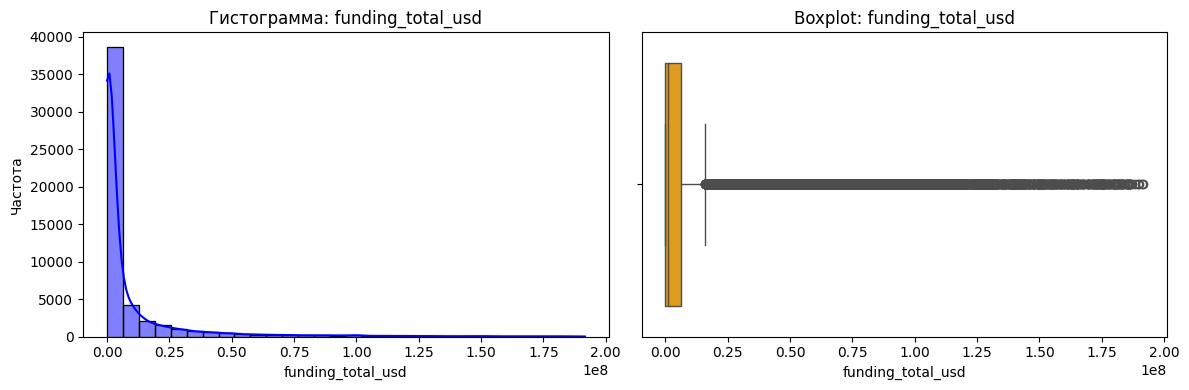


📊 Дискретный числовой признак: funding_rounds (уникальных значений: 18)


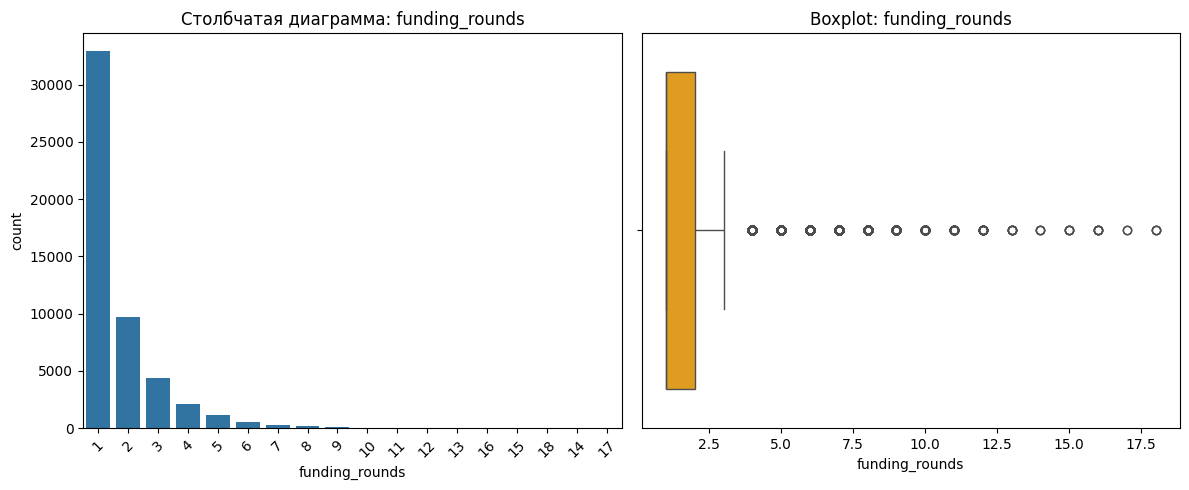


📈 Непрерывный числовой признак: lifetime (уникальных значений: 5706)


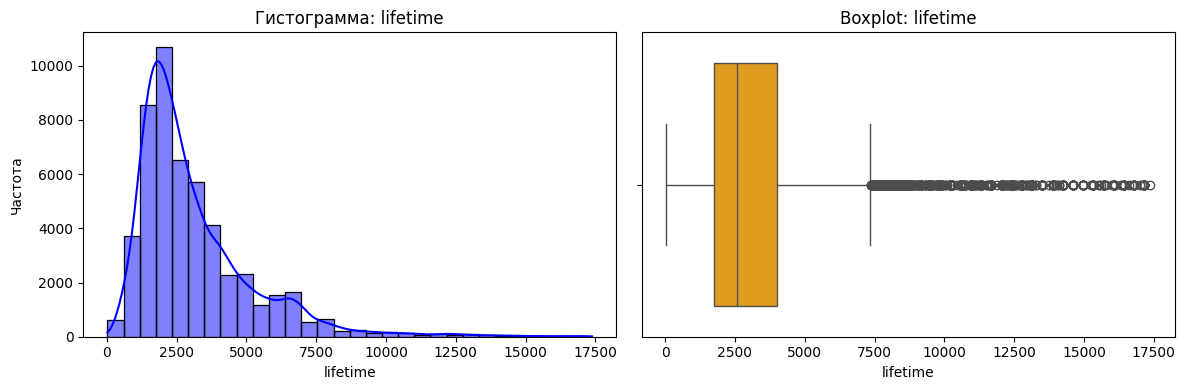


📈 Непрерывный числовой признак: funding_dt_diff (уникальных значений: 3162)


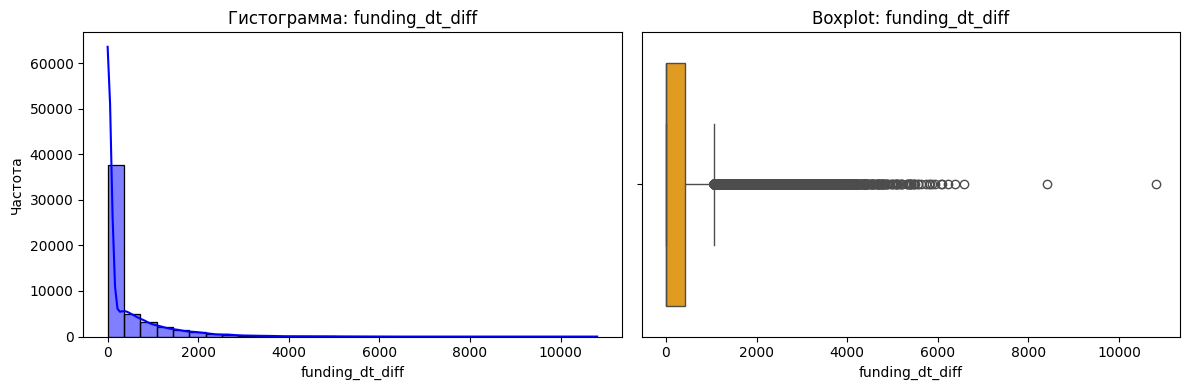


⚠️ Пропущен категориальный признак 'category_list' — слишком много уникальных значений (21920).

📚 Категориальный признак: status (уникальных значений: 2)


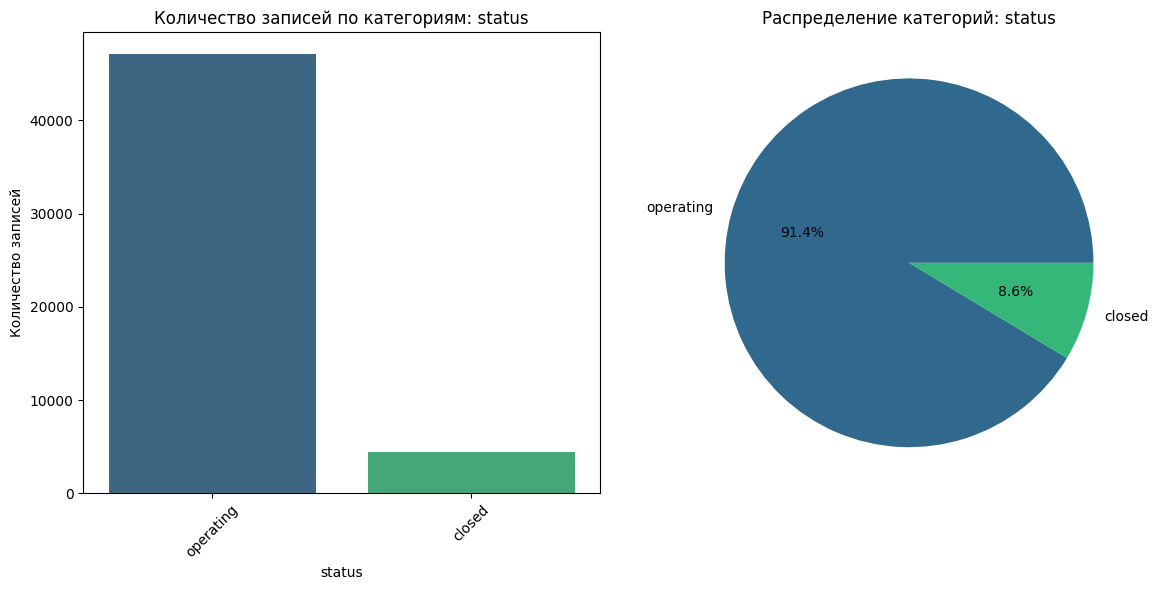


📚 Категориальный признак: country_code (уникальных значений: 132)


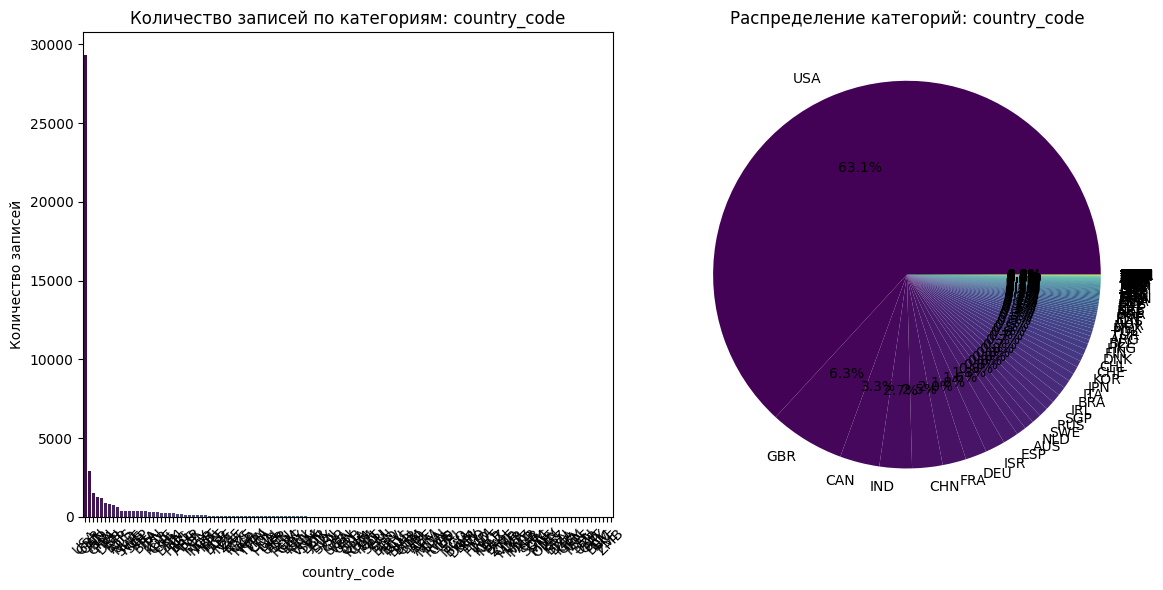


📚 Категориальный признак: state_code (уникальных значений: 300)


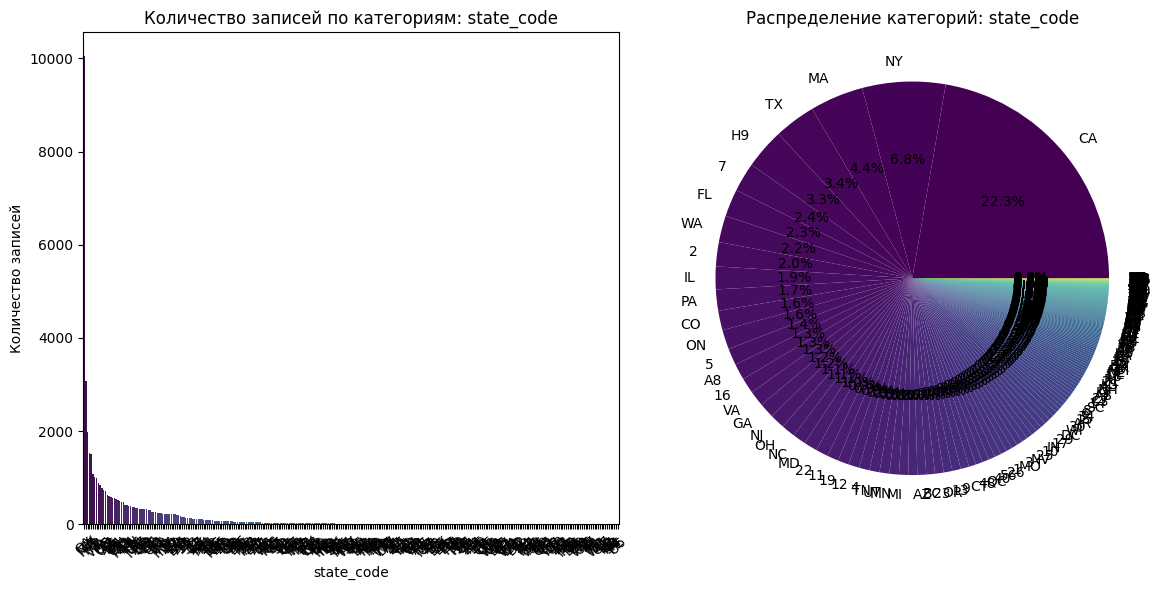


⚠️ Пропущен категориальный признак 'region' — слишком много уникальных значений (1034).

⚠️ Пропущен категориальный признак 'city' — слишком много уникальных значений (4449).

⚠️ Пропущен категориальный признак 'founded_at' — слишком много уникальных значений (5347).

⚠️ Пропущен категориальный признак 'first_funding_at' — слишком много уникальных значений (4573).

⚠️ Пропущен категориальный признак 'last_funding_at' — слишком много уникальных значений (4278).

⚠️ Пропущен категориальный признак 'closed_at' — слишком много уникальных значений (2827).


In [42]:
#построим гисторграммы и боксплот для всех числовых полей и столбчатую диаграмму для всех категориальных
plot_eda(train_df.drop(columns=list(all_categories) + ['category_list_clean']), hist_bins=30, max_discrete_values=20, max_categories=300)

In [43]:
# вывдем статистическую информацию по числовым полям
train_df.drop(columns=list(all_categories) + ['category_list_clean']).describe()

,funding_total_usd,funding_rounds,lifetime,funding_dt_diff
count,5.155400e+04,51554.000000,51554.000000,51554.000000
mean,8.891035e+06,1.723028,3139.680568,339.442875
std,2.134207e+07,1.324710,2132.287285,673.366776
min,0.000000e+00,1.000000,19.000000,0.000000
25%,4.125000e+04,1.000000,1757.000000,0.000000
50%,1.000000e+06,1.000000,2557.000000,0.000000
75%,6.439947e+06,2.000000,3996.750000,423.000000
max,1.915770e+08,18.000000,17378.000000,10807.000000


In [44]:
train_df.groupby('status')['lifetime'].median()

status
closed       1013.0
operating    2557.0
Name: lifetime, dtype: float64

In [45]:
train_df.groupby('status')['funding_total_usd'].median()

status
closed        823459.578961
operating    1000000.000000
Name: funding_total_usd, dtype: float64

In [46]:
train_df.groupby('status')['funding_dt_diff'].mean()

status
closed       195.190840
operating    353.084034
Name: funding_dt_diff, dtype: float64

Вывод:\
Распределение объема финансирования компании сильно скошенное, мединнай объем привлеченного финансирования составляет 1 млн, у закрытых компаний этот показатель примерно на 18% меньше.\
Медианное кол-во дней существования компании на дату надблюдения составляет 2557 дней, при этом у закрытых компаний этот показатель составляет 1013 дней.\
Доля закрытых компаний в выборке соствляет 8.6%.\
Большинство компаний в представленной выборке из США, что составляет 63,1%.

## Тестовые данные


📈 Непрерывный числовой признак: funding_total_usd (уникальных значений: 4550)


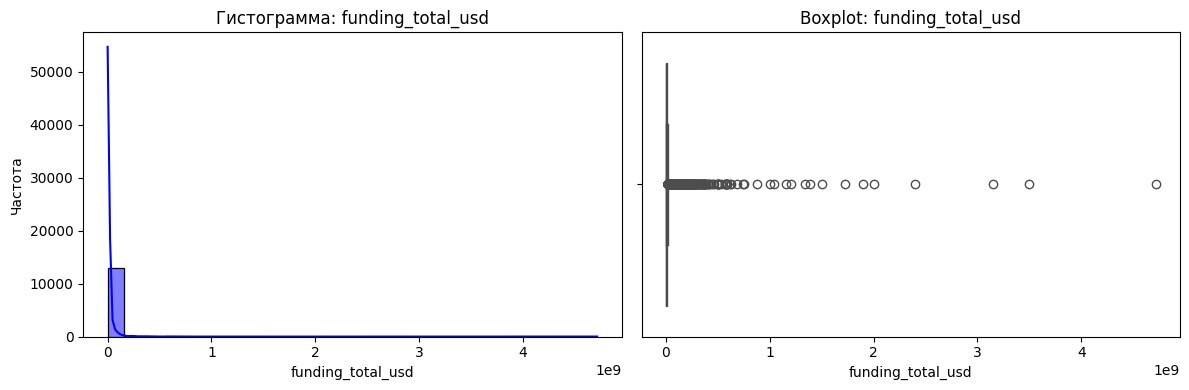


📊 Дискретный числовой признак: funding_rounds (уникальных значений: 15)


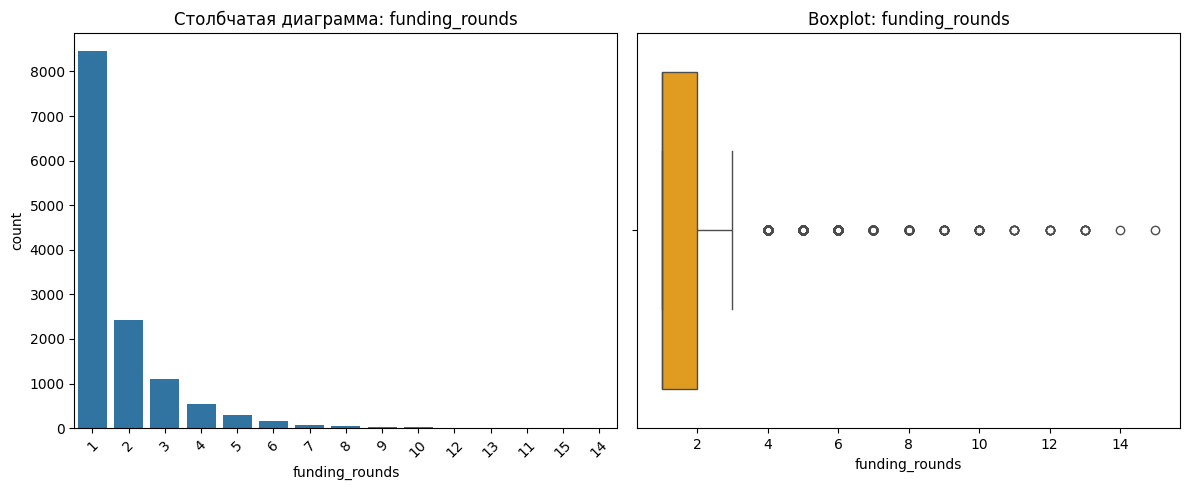


📈 Непрерывный числовой признак: lifetime (уникальных значений: 3456)


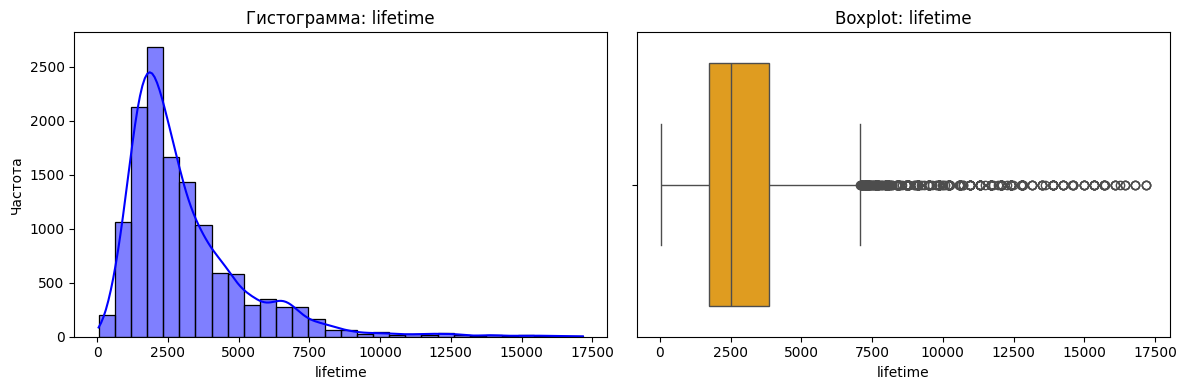


📈 Непрерывный числовой признак: funding_dt_diff (уникальных значений: 1986)


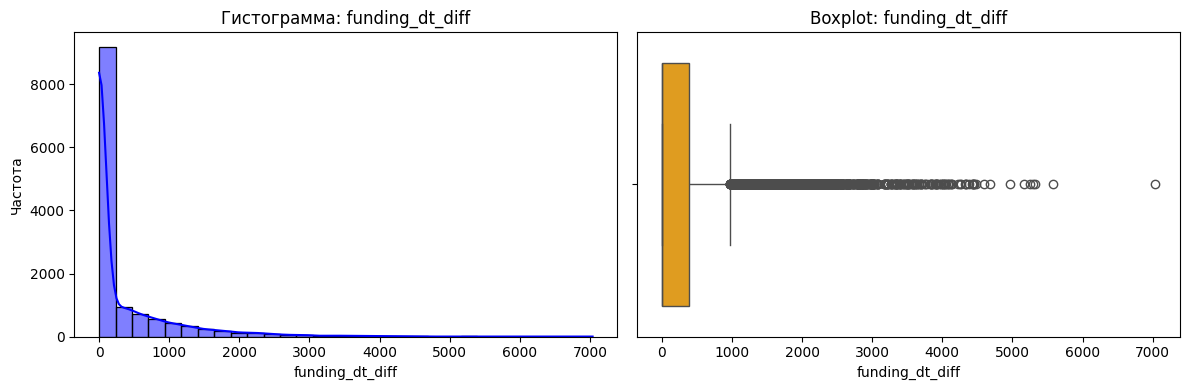


⚠️ Пропущен категориальный признак 'category_list' — слишком много уникальных значений (6207).

📚 Категориальный признак: country_code (уникальных значений: 96)


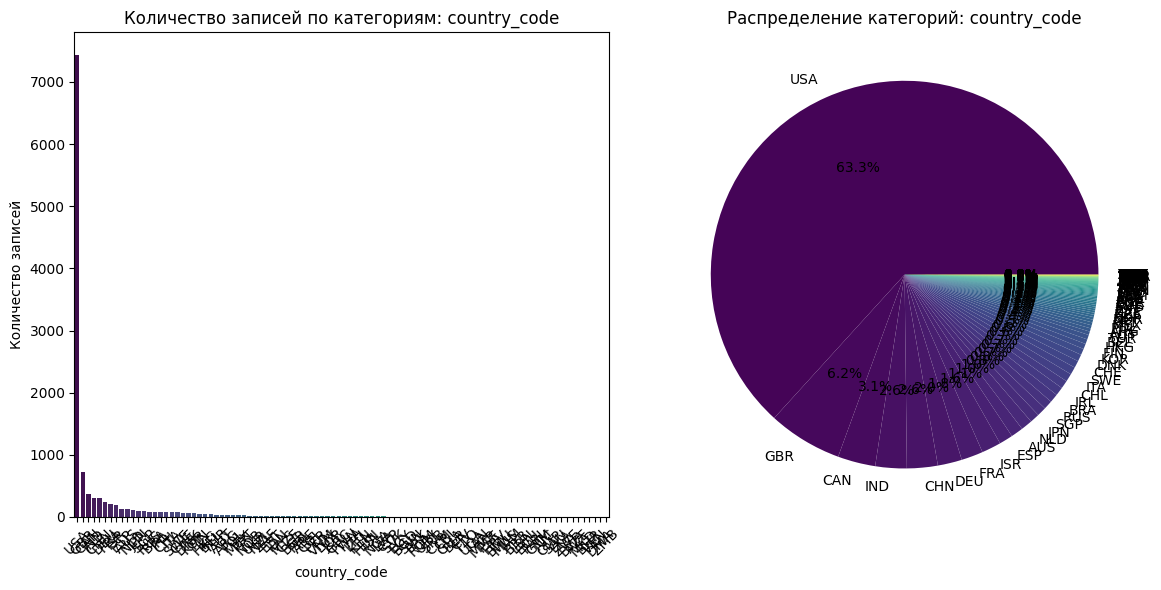


📚 Категориальный признак: state_code (уникальных значений: 235)


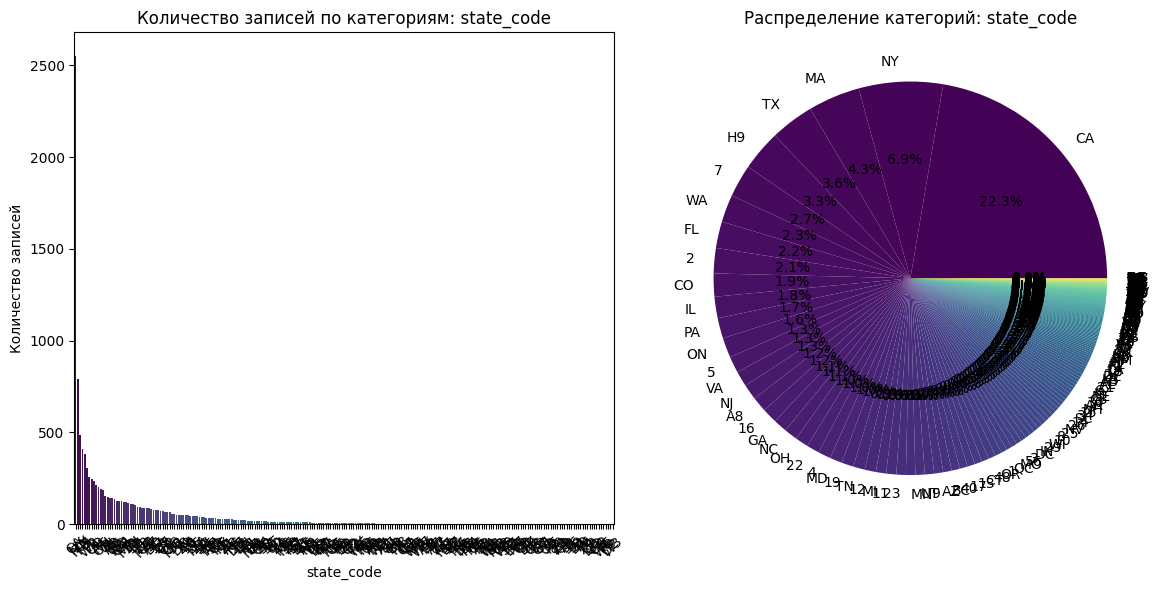


⚠️ Пропущен категориальный признак 'region' — слишком много уникальных значений (688).

⚠️ Пропущен категориальный признак 'city' — слишком много уникальных значений (2117).

⚠️ Пропущен категориальный признак 'first_funding_at' — слишком много уникальных значений (3299).

⚠️ Пропущен категориальный признак 'last_funding_at' — слишком много уникальных значений (3021).


In [47]:
#построим гисторграммы и боксплот для всех числовых полей и столбчатую диаграмму для всех категориальных
plot_eda(test_df.drop(columns=list(all_categories) + ['category_list_clean']), hist_bins=30, max_discrete_values=20, max_categories=300)

In [48]:
# вывдем статистическую информацию по числовым полям
test_df.drop(columns=list(all_categories) + ['category_list_clean']).describe()

,funding_total_usd,funding_rounds,lifetime,funding_dt_diff
count,1.312500e+04,13125.000000,13125.000000,13125.000000
mean,1.329854e+07,1.714438,3097.609524,328.339962
std,8.288661e+07,1.318800,2128.356554,658.073065
min,0.000000e+00,1.000000,52.000000,0.000000
25%,4.000000e+04,1.000000,1726.000000,0.000000
50%,9.500000e+05,1.000000,2526.000000,0.000000
75%,6.513865e+06,2.000000,3866.000000,391.000000
max,4.715000e+09,15.000000,17167.000000,7038.000000


Вывод:\
В целом выводы по тестовым данным аналогичны выводам по тренировочным данным, что хорошо, т.к. данные однородны.

## Общий вывод

Распределение объема финансирования компании сильно скошенное, мединнай объем привлеченного финансирования составляет 1 млн, у закрытых компаний этот показатель примерно на 18% меньше.\
Медианное кол-во дней существования компании на дату надблюдения составляет 2557 дней, при этом у закрытых компаний этот показатель составляет 1013 дней.\
Доля закрытых компаний в выборке соствляет 8.6%.\
Большинство компаний в представленной выборке из США, что составляет 63,1%.

В целом выводы по тестовым данным аналогичны выводам по тренировочным данным, что хорошо, т.к. данные однородны.

# Корреляционный анализ признаков

In [49]:
def custom_plot_correlation_matrix(df, method='pearson', figsize=(10, 8), annot=True):
    # Исключаем столбцы, содержащие 'id'
    filtered_df = df[[col for col in df.columns if 'id' not in col.lower()]]
    # Выбираем только числовые признаки
    numeric_df = filtered_df.select_dtypes(include=['number'])
    
    # Проверяем, есть ли числовые признаки
    if numeric_df.empty:
        print("В DataFrame нет числовых признаков.")
        return
    
    # Расчёт матрицы корреляций
    correlation_matrix = numeric_df.corr(method=method)
    
    # Построение тепловой карты
    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix, annot=annot, fmt='.2f', cmap='coolwarm', cbar=True)
    plt.title(f'Матрица корреляций ({method})')
    plt.show()

## Тренировочная выборка

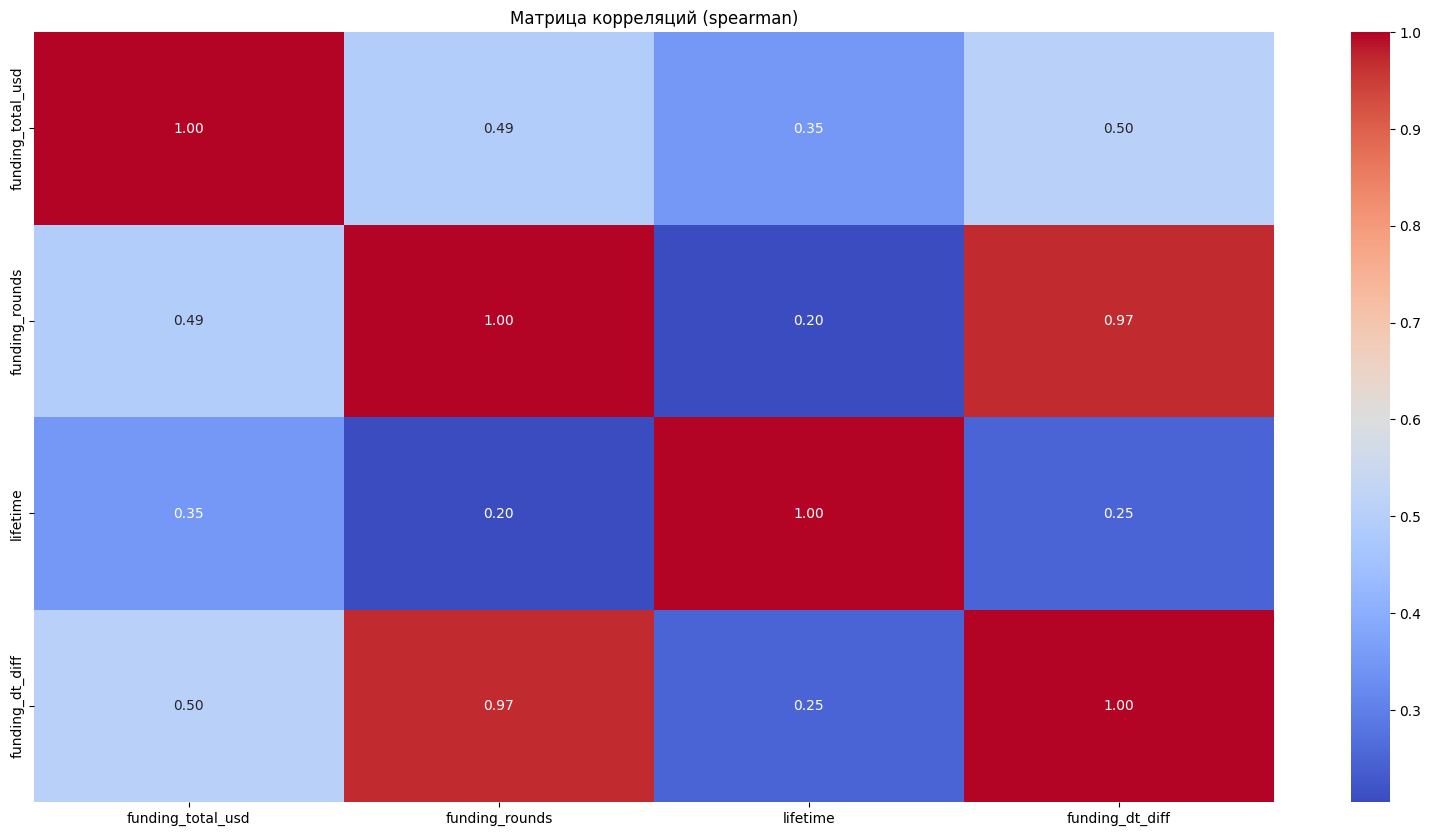

In [50]:
# т.к. данные распределены ненормально, то используем метод Спирмана
# из корреляционного анализа исключаем признаки, которые имеют слишком много уникальных значений и могу исказить результаты, 
# а также явно зависимые признаки такие как дата основания и lifetime
custom_plot_correlation_matrix(train_df.drop(columns=list(all_categories) + ['category_list_clean', 'category_list', 'category_list_clean', 
                       'name', 'founded_at', 'closed_at', 'first_funding_at', 'last_funding_at']), method='spearman', figsize=(20, 10), annot=True)

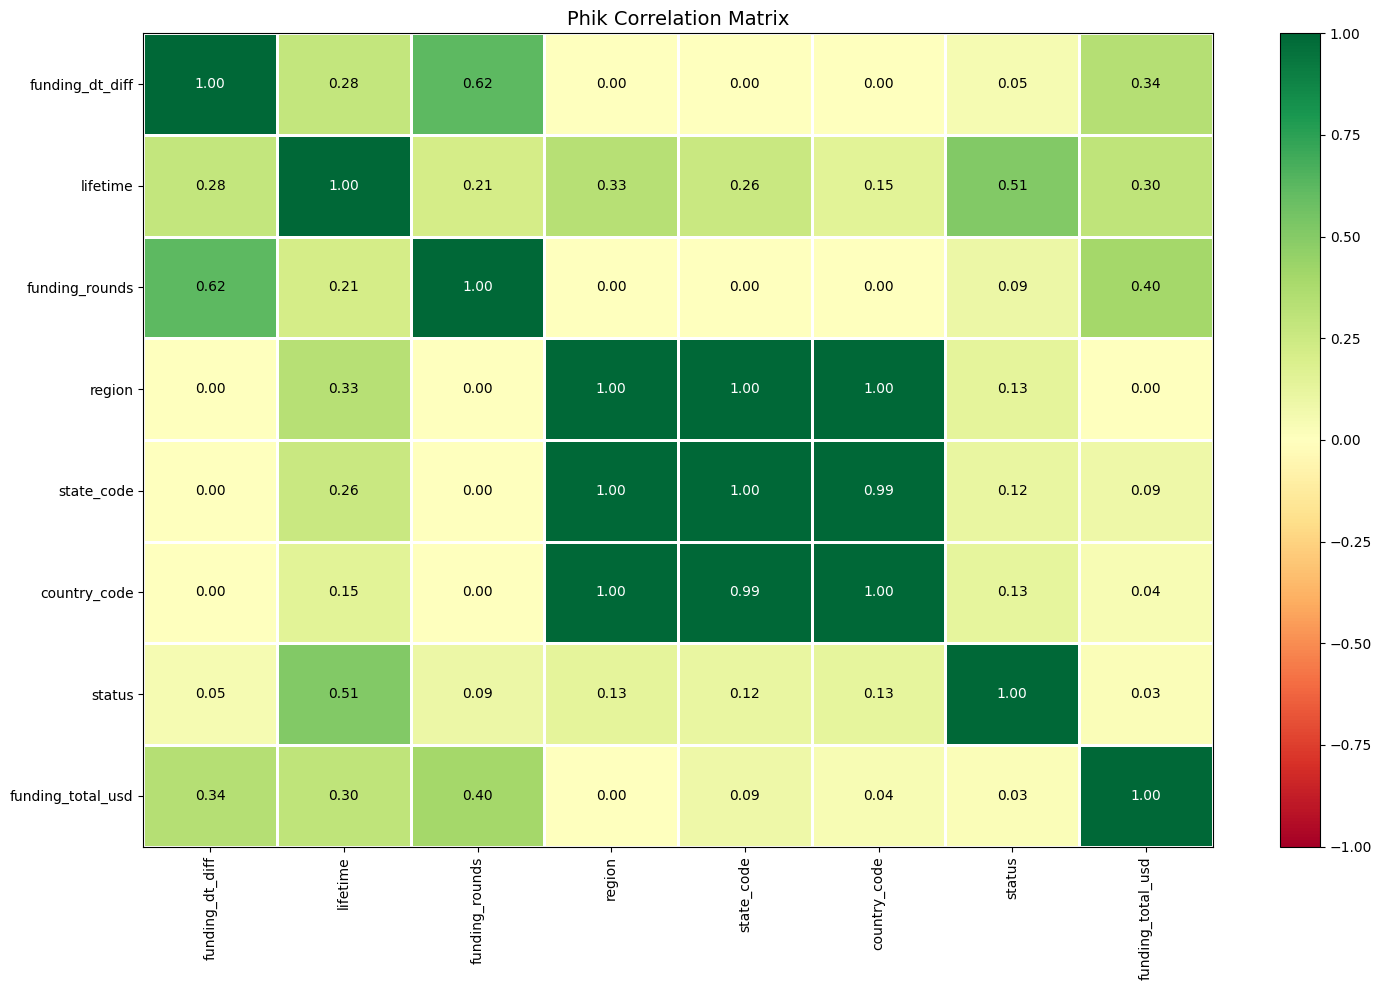

In [51]:
# проверим зависимость от всех признаков, в том числе категориальных, используя phik
columns_to_analyze = [col for col in train_df.drop(columns=list(all_categories) + ['category_list_clean', 'category_list', 'category_list_clean', 
                       'name', 'founded_at', 'closed_at', 'first_funding_at', 'last_funding_at', 'city']).columns if 'id' not in col.lower() 
                      and 'name' not in col.lower()]

# определение непрерывных признаков
interval_cols = train_df.select_dtypes(include=['float', 'int']).columns
interval_cols = [col for col in interval_cols if train_df[col].nunique() > 20] 

phik_corr_matrix = train_df[columns_to_analyze].phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_corr_matrix.values,
                        x_labels=phik_corr_matrix.columns,
                        y_labels=phik_corr_matrix.index,
                        title="Phik Correlation Matrix",
                        figsize=(15, 10))
plt.show()

Вывод:\
Видна достаточно сильная корреляция целевого признака и кол-ва дней существования компании, с остальными признаками корреляция слабая.\
Объем привлеченных инвестиций также коррелирует с кол-вом дней существований компании, кол-вом дней между первым и последним райндом финансирования и кол-вом раундов финансирования.\
При этом кол-во дней существования и между раундами коррелирует друг с другом.\
Корреляция между категориями стартаппов и другими признаками слабая. 

## Тестовая выборка

Аналогично посмотрим на тестовые данные:

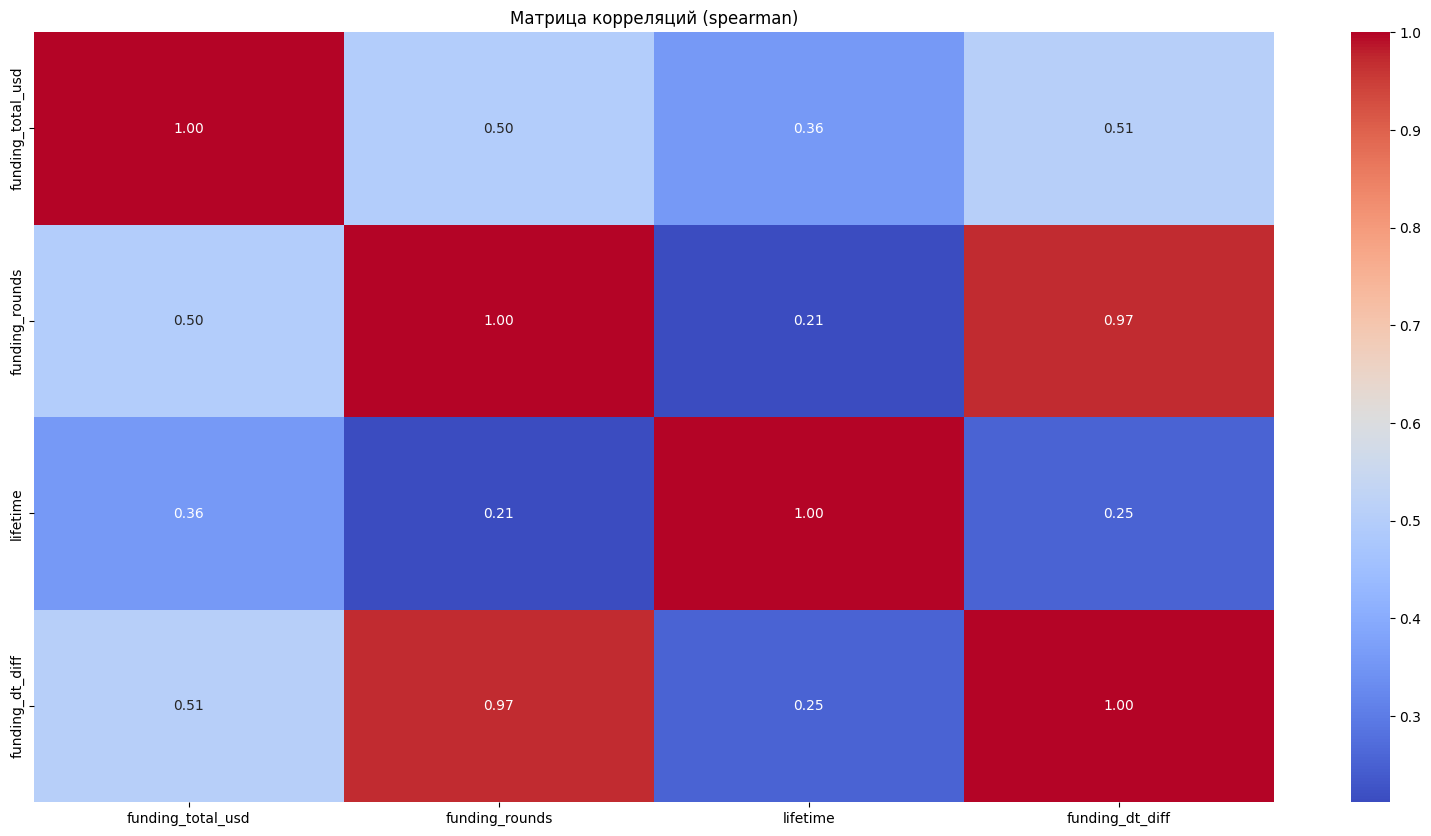

In [52]:
custom_plot_correlation_matrix(test_df.drop(columns=list(all_categories) + ['category_list_clean', 'category_list', 'category_list_clean', 
                       'name', 'first_funding_at', 'last_funding_at', 'city']), method='spearman', figsize=(20, 10), annot=True)

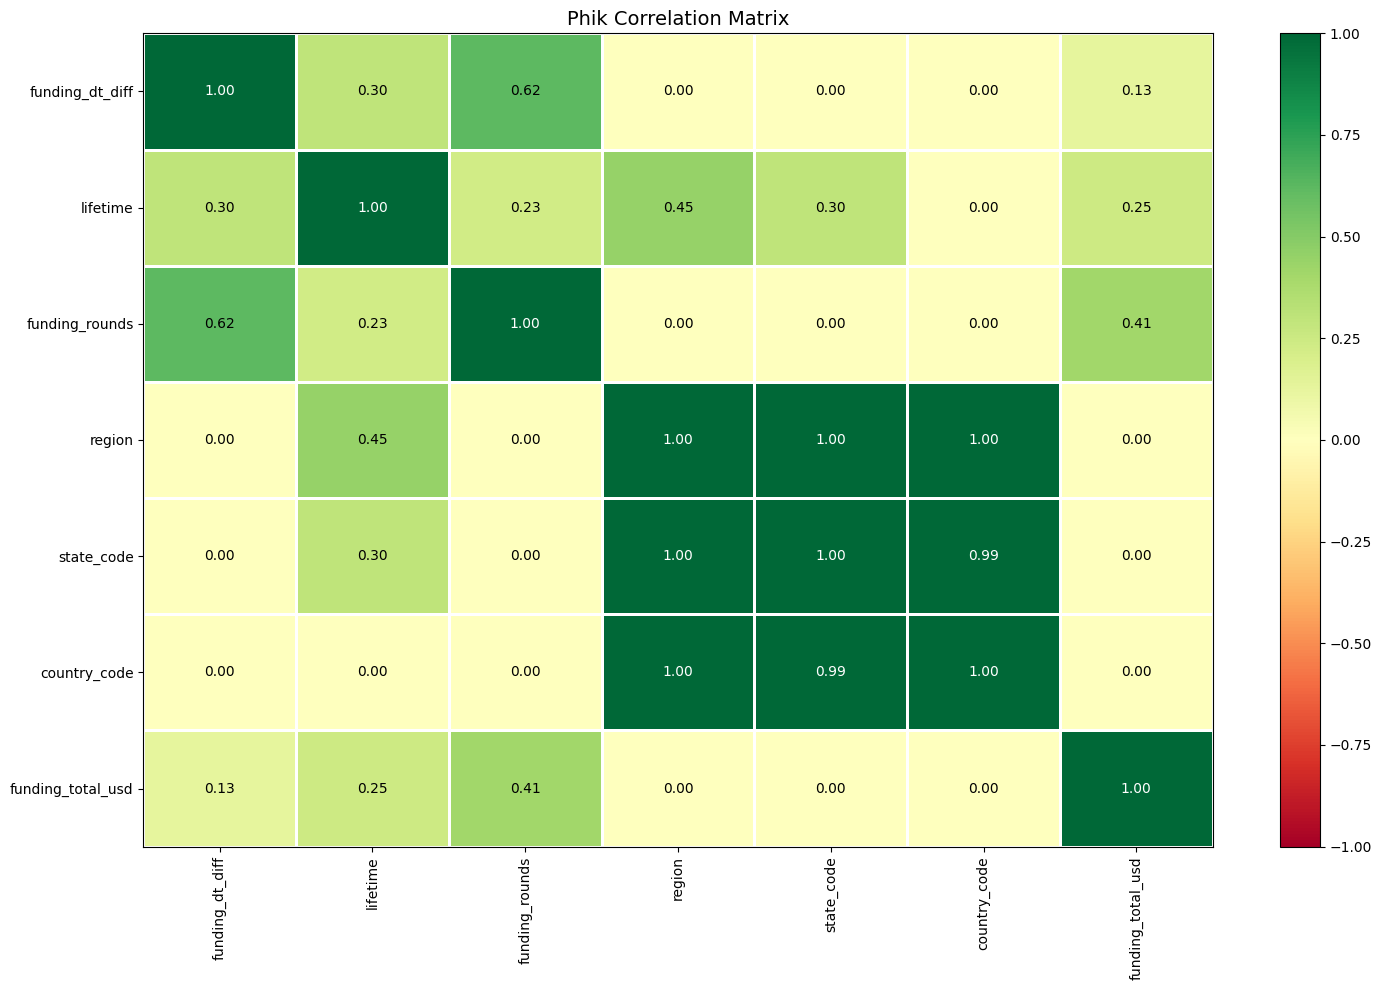

In [53]:
# проверим зависимость от всех признаков, в том числе категориальных, используя phik
columns_to_analyze = [col for col in test_df.drop(columns=list(all_categories) + ['category_list_clean', 'category_list', 'category_list_clean', 
                       'name', 'first_funding_at', 'last_funding_at', 'city']).columns if 'id' not in col.lower() 
                      and 'name' not in col.lower()]

# определение непрерывных признаков
interval_cols = test_df.select_dtypes(include=['float', 'int']).columns
interval_cols = [col for col in interval_cols if test_df[col].nunique() > 20] 

phik_corr_matrix = test_df[columns_to_analyze].phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_corr_matrix.values,
                        x_labels=phik_corr_matrix.columns,
                        y_labels=phik_corr_matrix.index,
                        title="Phik Correlation Matrix",
                        figsize=(15, 10))
plt.show()

## Общий вывод

На основе матрицы корреляций для тренировочной выборки, можно сделать следующие выводы:

Видна достаточно сильная корреляция целеового признака и кол-ва дней существования компании, с остальными признаками корреляция слабая.\
Объем привлеченных инвестиций также коррелирует с кол-вом дней существований компании, кол-вом дней между первым и последним райндом финансирования и кол-вом раундов финансирования.\
При этом кол-во дней существования и между раундами коррелирует друг с другом.\
Корреляция между категориями стартаппов и другими признаками слабая. 

На тестовой выборке зависимости аналогичны, немного отличаются значения, но характер остается такой же как и на тренировочной, существенных различий не обнаружено. 

# Моделирование

Для выполнения задания будем решать задачу классификации, необходимо предсказать закроется компания или нет.\
Целевой признак - status.\
В качестве основной метрики примем F1-Score.

F1-мера вычисляется на основе точности p и полноты r. Точность - это отношение true positives (tp) ко всем predicted positives (tp + fp). Полнота это отношение true positives ко всем actual positives (tp + fn).

## Модель

In [54]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

In [55]:
X_train = train_df.drop(columns=['category_list', 'category_list_clean', 
                       'name', 'founded_at', 'closed_at', 'first_funding_at', 'last_funding_at', 'status', 'state_code', 'city'])
y_train = train_df['status']

In [56]:
X_train.columns

Index(['funding_total_usd', 'country_code', 'region', 'funding_rounds',
       'lifetime', 'funding_dt_diff', 'networking', 'material science', 'film',
       'tourism',
       ...
       'cyber security', 'mobile search', 'mobile infrastructure',
       'test and measurement', 'lighting', 'business intelligence',
       'water purification', 'real estate investors', 'facebook applications',
       'hi tech'],
      dtype='object', length=861)

In [57]:
y_train_enc = np.where(y_train == 'closed', 1, 0)

In [58]:
unique_vals, counts = np.unique(y_train_enc, return_counts=True)
print("Уникальные значения:", unique_vals)
print("Количество:", counts)

Уникальные значения: [0 1]
Количество: [47100  4454]


Преобразование категориальных переменных выполним методом TargetEncoder, кросс-валидацию методом OptunaSearchCV:

In [59]:
one_hot_columns = list(all_categories)
tr_columns = ['country_code', 'region']
num_columns = ['funding_total_usd', 'funding_rounds', 'lifetime', 'funding_dt_diff']

bin_pipe = Pipeline([
    ('impute_bin', SimpleImputer(strategy='constant', fill_value=0)) 
])

tr_pipe = Pipeline([
    ('target_enc', TargetEncoder(cols=tr_columns))
])

num_pipe = Pipeline([
    ('impute_num', SimpleImputer(strategy='median')),
    ('scale', MinMaxScaler())
])

data_preprocessor = ColumnTransformer([
    ('target', tr_pipe, tr_columns),
    ('num', num_pipe, num_columns),
    ('bin', bin_pipe, one_hot_columns)
], remainder='drop')

pipe_base = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])


def run_optuna_search(estimator_pipeline, param_dists, X_train, y_train,
                      scoring='f1', n_trials=30):
    search = OptunaSearchCV(
        estimator=estimator_pipeline,
        param_distributions=param_dists,
        scoring=scoring,
        cv=5,
        n_trials=n_trials,
        random_state=RANDOM_STATE,
        n_jobs=1,
        timeout=300
    )
    search.fit(X_train, y_train)
    return search


param_distributions_dt = {
    'models': optuna.distributions.CategoricalDistribution([
        DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')
    ]),
    'models__max_depth': optuna.distributions.IntDistribution(2, 20),
    'models__max_features': optuna.distributions.IntDistribution(1, len(num_columns)),
    'preprocessor__num__scale': optuna.distributions.CategoricalDistribution([
        StandardScaler(), MinMaxScaler(), 'passthrough'
    ])
}

param_distributions_knn = {
    'models': optuna.distributions.CategoricalDistribution([
        KNeighborsClassifier()
    ]),
    'models__n_neighbors': optuna.distributions.IntDistribution(2, 20),
    'preprocessor__num__scale': optuna.distributions.CategoricalDistribution([
        StandardScaler(), MinMaxScaler(), 'passthrough'
    ])
}

param_distributions_lr_l1 = {
    'models': optuna.distributions.CategoricalDistribution([
        LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1',
            class_weight='balanced'
        )
    ]),
    'models__C': optuna.distributions.CategoricalDistribution([0.01, 0.1, 1, 10, 100, 1000, 10000]),
    'preprocessor__num__scale': optuna.distributions.CategoricalDistribution([
        StandardScaler(), MinMaxScaler(), 'passthrough'
    ])
}

param_distributions_lr_l2 = {
    'models': optuna.distributions.CategoricalDistribution([
        LogisticRegression(
            random_state=RANDOM_STATE,
            solver='lbfgs',
            penalty='l2',
            class_weight='balanced'
        )
    ]),
    'models__C': optuna.distributions.CategoricalDistribution([0.01, 0.1, 1, 10, 100, 1000, 10000]),
    'preprocessor__num__scale': optuna.distributions.CategoricalDistribution([
        StandardScaler(), MinMaxScaler(), 'passthrough'
    ])
}

catboost_pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', CatBoostClassifier(verbose=0, random_state=RANDOM_STATE))
])

param_distributions_catboost = {
    'models__scale_pos_weight': optuna.distributions.FloatDistribution(1, 15),
    'models__iterations': optuna.distributions.IntDistribution(100, 1000),
    'models__learning_rate': optuna.distributions.FloatDistribution(0.01, 0.3),
    'models__bagging_temperature': optuna.distributions.FloatDistribution(0.0, 1.0),
    'models__random_strength': optuna.distributions.FloatDistribution(1e-9, 10),
    # 'models__depth': optuna.distributions.IntDistribution(3, 10),
    # 'models__learning_rate': optuna.distributions.FloatDistribution(0.01, 0.3),
    # 'models__l2_leaf_reg': optuna.distributions.IntDistribution(1, 10)
}

# --- ЗАПУСК ---
search_dt    = run_optuna_search(pipe_base, param_distributions_dt,     X_train, y_train_enc)
search_knn   = run_optuna_search(pipe_base, param_distributions_knn,    X_train, y_train_enc)
search_lr_l1 = run_optuna_search(pipe_base, param_distributions_lr_l1,  X_train, y_train_enc)
search_lr_l2 = run_optuna_search(pipe_base, param_distributions_lr_l2,  X_train, y_train_enc)
search_cat   = run_optuna_search(catboost_pipeline, param_distributions_catboost, X_train, y_train_enc)

# --- ВЫВОД РЕЗУЛЬТАТОВ ---
def print_metrics(name, model, X, y):
    """Вывод Accuracy, Precision, Recall, F1, ROC AUC (если возможно)."""
    y_pred = model.predict(X)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X)[:, 1]
    else:
        y_proba = None
    
    print(f"=== {name} ===")
    print("Лучшие параметры:", model.best_params_)
    print(f"F1-score: {f1_score(y, y_pred):.4f}")
    print(f"Accuracy: {accuracy_score(y, y_pred):.4f}")
    print(f"Precision: {precision_score(y, y_pred):.4f}")
    print(f"Recall: {recall_score(y, y_pred):.4f}")
    if y_proba is not None:
        print(f"ROC AUC: {roc_auc_score(y, y_proba):.4f}")
    print()

print_metrics("DecisionTree", search_dt, X_train, y_train_enc)
print_metrics("KNN",          search_knn, X_train, y_train_enc)
print_metrics("LogReg (l1)",  search_lr_l1, X_train, y_train_enc)
print_metrics("LogReg (l2)",  search_lr_l2, X_train, y_train_enc)
print_metrics("CatBoost",     search_cat, X_train, y_train_enc)

# Итоговое сравнение
results = {
    'DecisionTree': search_dt.best_score_,
    'KNN':          search_knn.best_score_,
    'LR_l1':        search_lr_l1.best_score_,
    'LR_l2':        search_lr_l2.best_score_,
    'CatBoost':     search_cat.best_score_
}

best_model_name = max(results, key=results.get)
best_model = {
    'DecisionTree': search_dt,
    'KNN': search_knn,
    'LR_l1': search_lr_l1,
    'LR_l2': search_lr_l2,
    'CatBoost': search_cat
}[best_model_name]

y_pred = best_model.predict(X_train)
if hasattr(best_model, "predict_proba"):
    y_proba = best_model.predict_proba(X_train)[:, 1]
else:
    y_proba = None

print(f"Лучшая модель по среднему значению метрики F1 на кросс-валидации: {best_model_name}")
print(f"F1-score: {f1_score(y_train_enc, y_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_train_enc, y_pred):.4f}")
print(f"Precision: {precision_score(y_train_enc, y_pred):.4f}")
print(f"Recall: {recall_score(y_train_enc, y_pred):.4f}")
if y_proba is not None:
    print(f"ROC AUC: {roc_auc_score(y_train_enc, y_proba):.4f}")

[I 2025-04-03 13:23:59,087] A new study created in memory with name: no-name-88cc6e9a-e9af-4e0c-b5d9-b73c512791ce
[I 2025-04-03 13:24:04,978] Trial 0 finished with value: 0.15982784523646332 and parameters: {'models': DecisionTreeClassifier(class_weight='balanced', max_depth=10, max_features=4,
                       random_state=42), 'models__max_depth': 10, 'models__max_features': 4, 'preprocessor__num__scale': 'passthrough'}. Best is trial 0 with value: 0.15982784523646332.
[I 2025-04-03 13:24:10,705] Trial 1 finished with value: 0.038573948605848424 and parameters: {'models': DecisionTreeClassifier(class_weight='balanced', max_depth=7, max_features=1,
                       random_state=42), 'models__max_depth': 7, 'models__max_features': 1, 'preprocessor__num__scale': 'passthrough'}. Best is trial 0 with value: 0.15982784523646332.
[I 2025-04-03 13:24:16,639] Trial 2 finished with value: 0.15924294740965644 and parameters: {'models': DecisionTreeClassifier(class_weight='balanced',

=== DecisionTree ===
Лучшие параметры: {'models': DecisionTreeClassifier(class_weight='balanced', max_depth=13, max_features=1,
                       random_state=42), 'models__max_depth': 20, 'models__max_features': 2, 'preprocessor__num__scale': 'passthrough'}
F1-score: 0.2418
Accuracy: 0.7985
Precision: 0.1791
Recall: 0.3720
ROC AUC: 0.6126

=== KNN ===
Лучшие параметры: {'models': KNeighborsClassifier(n_neighbors=3), 'models__n_neighbors': 5, 'preprocessor__num__scale': 'passthrough'}
F1-score: 0.6271
Accuracy: 0.9502
Precision: 0.8877
Recall: 0.4847
ROC AUC: 0.9697

=== LogReg (l1) ===
Лучшие параметры: {'models': LogisticRegression(C=0.1, class_weight='balanced', penalty='l1',
                   random_state=42, solver='liblinear'), 'models__C': 0.1, 'preprocessor__num__scale': 'passthrough'}
F1-score: 0.4273
Accuracy: 0.7998
Precision: 0.2838
Recall: 0.8642
ROC AUC: 0.8973

=== LogReg (l2) ===
Лучшие параметры: {'models': LogisticRegression(C=100, class_weight='balanced', rando

## Проверка модели на адекватность

In [60]:
# Проверим модель на адекватность при помощи DummyClassifier
dummy_clf = DummyClassifier(strategy='most_frequent')

dummy_clf.fit(X_train, y_train_enc)

dummy_pred = dummy_clf.predict(X_train)
dummy_proba = dummy_clf.predict_proba(X_train)[:, 1]

dummy_auc = roc_auc_score(y_train_enc, dummy_proba)
dummy_acc = accuracy_score(y_train_enc, dummy_pred)
dummy_precision = precision_score(y_train_enc, dummy_pred, zero_division=0)
dummy_recall = recall_score(y_train_enc, dummy_pred, zero_division=0)
dummy_f1 = f1_score(y_train_enc, dummy_pred, zero_division=0)


print("Метрики для DummyClassifier:")
print(f"ROC AUC:    {dummy_auc:.4f}")
print(f"Accuracy:   {dummy_acc:.4f}")
print(f"Precision:  {dummy_precision:.4f}")
print(f"Recall:     {dummy_recall:.4f}")
print(f"F1-score:   {dummy_f1:.4f}")

Метрики для DummyClassifier:
ROC AUC:    0.5000
Accuracy:   0.9136
Precision:  0.0000
Recall:     0.0000
F1-score:   0.0000


Полученные метрики модели существенно лучше, чем рандомные.

## Анализ важности признаков

In [61]:
best_estimator = search_cat.best_estimator_

In [62]:
from catboost import Pool

In [63]:
catboost_model = best_estimator.named_steps['models']

In [64]:
preprocessor = best_estimator.named_steps["preprocessor"]

# В scikit-learn 1.0+ ColumnTransformer/ Pipeline имеют метод get_feature_names_out
# (если все используемые внутри трансформеры тоже возвращают имена).
# Если используете старую версию sklearn или трансформеры без имён — будет сложнее.
transformed_feature_names = list(preprocessor.get_feature_names_out(input_features=X_train.columns))

X_transformed = preprocessor.transform(X_train)

cat_pool = Pool(
    data=X_transformed, 
    label=y_train_enc,
    feature_names=transformed_feature_names
)

cb_imp_df = catboost_model.get_feature_importance(cat_pool, prettified=True)

# Переименуем столбцы, чтобы стало понятнее
cb_imp_df.rename(columns={
    'Feature Id': 'feature_name',
    'Importances': 'importance'
}, inplace=True)

In [65]:
cb_imp_df.head(15)

,feature_name,importance
0,num__lifetime,55.892251
1,num__funding_total_usd,8.368635
2,target__region,5.400535
3,num__funding_dt_diff,3.612629
4,target__country_code,2.538874
5,bin__unknown,2.026842
6,num__funding_rounds,1.180344
7,bin__curated web,0.969642
8,bin__software,0.558166
9,bin__real estate,0.439856


Вывод:\
Ключевой признак:

num__lifetime (возраст компании) — наиболее важный фактор с весом 56%. Это означает, что длительность существования компании является главным предиктором целевой переменной. Модель сильно опирается на этот показатель при принятии решения.

Финансовые признаки:

num__funding_total_usd (8.5%) и num__funding_dt_diff (3.5%) также играют заметную роль. Общий объём привлечённых средств и временной интервал между раундами инвестиций позволяют оценить динамику роста стартапа.

num__funding_rounds — чуть менее значимый (1.1%), но тоже отражает активность компании на инвестиционном рынке.

География:

target__region (5.1%) и target__country_code (2.5%) дают понять, что локация компании влияет на целевую переменную — вероятно, из-за различий в рыночной среде, доступе к инвестициям или законодательстве.

Категориальные бинарные признаки:

Все признаки вида bin__... имеют относительно низкую индивидуальную важность (менее 1%), но в совокупности могут давать полезную информацию.

## Предсказания на тестовых данных

In [66]:
X_test = test_df.drop(columns=['category_list', 'category_list_clean', 
                       'name', 'first_funding_at', 'last_funding_at', 'state_code', 'city'])

In [67]:
X_test.head()

,funding_total_usd,country_code,region,funding_rounds,lifetime,funding_dt_diff,networking,material science,film,tourism,semantic web,fintech,application platforms,sms,university students,temporary staffing,travel & tourism,natural gas uses,pets,hospitals,uv leds,event management,cad,polling,indians,social investing,hardware,classifieds,disruptive models,aerospace,serious games,linux,rural energy,personal health,health care information technology,career management,health and wellness,real estate,mothers,ios,messaging,cosmetics,contact centers,local advertising,financial exchanges,babies,new technologies,saas,geospatial,health diagnostics,product search,shipping,technical continuing education,local search,google apps,cyber,lingerie,mining technologies,oil and gas,mobile games,business services,apps,match-making,photo editing,events,business productivity,private social networking,trading,telephony,gift registries,employer benefits programs,animal feed,bpo services,soccer,online travel,knowledge management,news,edutainment,rapidly expanding,skill assessment,content creators,lotteries,quantified self,promotional,proximity internet,finance,e-books,early-stage technology,clean technology,online reservations,venture capital,infrastructure builders,biotechnology and semiconductor,nonprofits,smart building,auctions,weddings,development platforms,nanotechnology,local,freemium,interface design,parenting,gold,identity,microblogging,ride sharing,casual games,game,vulnerability management,semiconductor manufacturing equipment,invention,telecommunications,auto,web hosting,financial services,skate wear,consumer internet,risk management,mobile commerce,peer-to-peer,social media platforms,freetoplay gaming,gambling,video,timeshares,speech recognition,charities,air pollution control,human computer interaction,clinical trials,virtual currency,visualization,emerging markets,ipad,automated kiosk,search marketing,e-commerce,concerts,mens specific,pc gaming,collaborative consumption,enterprise security,flowers,sensors,health care,specialty foods,notebooks,3d,sustainability,charter schools,services,software,law enforcement,independent pharmacies,developer tools,data visualization,displays,funeral industry,tablets,ad targeting,natural resources,nfc,internet of things,plumbers,predictive analytics,portals,it and cybersecurity,taxis,iaas,enterprise resource planning,publishing,retail,nightlife,video on demand,paas,advertising networks,wealth management,multi-level marketing,forums,demographies,wine and spirits,fraud detection,farming,self storage,gadget,fmcg,computers,franchises,racing,sporting goods,cause marketing,browser extensions,cloud-based music,medical devices,ticketing,quantitative marketing,loyalty programs,independent music,social games,personalization,innovation management,medication adherence,senior health,specialty chemicals,enterprise software,web tools,video chat,lifestyle products,voip,twin-tip skis,postal and courier services,employment,consumer behavior,architecture,industrial,toys,labor optimization,energy it,insurance,operating systems,task management,resorts,high school students,food processing,utility land vehicles,social buying,human resources,career planning,diy,business information systems,digital media,digital entertainment,language learning,domains,home decor,startups,mobile security,assisted living,mobile software tools,home renovation,contact management,web presence management,offline businesses,semantic search,film production,ict,productivity,translation,outsourcing,independent music labels,commercial solar,mmo games,qr codes,carbon,music venues,mobile emergency&health,medical,veterinary,building owners,optimization,online rental,online education,outdoors,sunglasses,public transportation,data security,face recognition,social fundraising,interest graph,k-12 education,computer vision,broadcasting,podcast,groceries,windows phone 7,brokers,coupons,m2m,surveys,healthcare services,bitcoin,game mechanics,recycling,seo,data center a

In [68]:
y_pred = best_estimator.predict(X_test) 

In [69]:
mapping = {1: 'closed', 0: 'operating'}
status_labels = pd.Series(y_pred).map(mapping)

# Склеиваем в итоговый DataFrame
final_df = pd.DataFrame({
    'name': test_df['name'],
    'status': status_labels
})

In [70]:
final_df.head()

,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,operating
3,Imagine Communications,operating
4,DNA13,operating


In [71]:
final_df.groupby('status')['name'].nunique()

status
closed        1295
operating    11830
Name: name, dtype: int64

In [72]:
#final_df.to_csv(r"C:\Users\bondarev\Documents\DS study\data\ms_1\final_df7.csv")

## Общий вывод

CatBoost показал наилучшие результаты по всем метрикам:

F1-score: 0.86

Accuracy: 0.97

ROC AUC: 0.99

Модель хорошо сбалансирована между Precision (0.79) и Recall (0.94), что особенно важно при наличии дисбаланса классов.

Подбор параметров через Optuna (включая scale_pos_weight, iterations, learning_rate, bagging_temperature, random_strength) позволил существенно повысить качество.

Logistic Regression (с L1 и L2 регуляризацией) показала хорошие показатели Recall (до 0.87) и достойный ROC AUC (~0.90), но при этом страдала Precision (~0.28–0.29), что снизило F1-score (~0.43).

KNN неожиданно показал высокий Precision (0.89) и ROC AUC (0.97), но при этом имел относительно низкий Recall (0.48), из-за чего F1-score составил 0.63. Это может быть полезно, если особенно важно избегать false positive.

Decision Tree продемонстрировала худшие результаты:

F1-score: 0.24, Recall: 0.37, Precision: 0.18

Несмотря на высокую Accuracy (0.79), модель практически не справляется с задачей в условиях дисбаланса, переобучаясь на большинство.

# Общий вывод по проекту

 1. Постановка задачи

    
Цель — построить модель, предсказывающую, закроется ли стартап или будет продолжать действовать.
Решалась задача бинарной классификации с сильно несбалансированным целевым признаком (status: operating vs closed), что потребовало особого подхода в выборе метрик и модели.

3. Работа с признаками и предобработка

   
Временные признаки были трансформированы в числовые (lifetime, funding_dt_diff), что позволило учесть динамику жизни стартапа.

Категориальные переменные (страна, город, регион) закодированы с помощью TargetEncoder, что хорошо подходит при большом количестве уникальных значений.

Бинарные признаки из category_list были преобразованы в one-hot в ручном виде (как bin__...) — они показали умеренную важность.

Числовые признаки масштабировались (MinMaxScaler / StandardScaler), в зависимости от модели.

Также применена импутация пропусков — медианой для числовых и "0" для бинарных категорий.

3. Сравнение моделей
   
Были обучены и подобраны с помощью OptunaSearchCV следующие модели:

DecisionTreeClassifier — показал слабые результаты, склонен к переобучению

KNeighborsClassifier — высокий precision, но низкий recall

LogisticRegression (L1, L2) — хорошие baseline-модели, уверенный recall, но низкий precision

 CatBoostClassifier — показал наилучшее качество по всем метрикам:

F1-score: 0.86

Recall: 0.94

ROC AUC: 0.99

Использование кастомных параметров (scale_pos_weight, iterations, learning_rate, bagging_temperature, random_strength) значительно повысило точность модели.

4. Важность признаков (feature importance)
   
Самый важный признак — lifetime стартапа (~56% вклада), отражающий жизненный цикл.

Далее следуют финансовые показатели (funding_total_usd, funding_dt_diff) и географическая информация (region, country_code).

Бинарные признаки из category_list имели невысокую индивидуальную важность, но могут усиливать модель в совокупности.

5. Рекомендации

Итоговая модель на основе CatBoost уверенно справляется с задачей предсказания закрытия стартапа, показывая высокую точность, полноту и устойчивость на тренировочных данных. Рекомендуется протестировать модель на финальном тестовом датасете и использовать её в боевых условиях/на новых данных.